# MODELO BASE - SEM GENERO E SEM UTILIZADOR: DUPLA OPTIMIZAÇÃO

# POR ACABAR !!!!!!!!!!

In [28]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 900,               # DPI for high-quality PNG/JPEG
})

# Load the data

In [29]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

In [30]:
with open("data/data_ids.json") as f:
    ids = json.load(f)

max_movieId = max(ids["moviesIDs"].values())
max_userId = max(ids["userIDs"].values())

# Create a matrix of users and movies
base_matrix = np.zeros((max_movieId + 1, max_userId + 1))
base_matrix.shape

(9633, 385)

# Define functions

In [31]:
# Utility matrix and Binary matrix
from scipy.sparse import lil_matrix

def utility_matrix_AND_binary_matrix(dfTrain, zerosMatrix = base_matrix, jsonIds = ids):
    Y = lil_matrix(zerosMatrix.shape)  # Use sparse matrix format
    R = lil_matrix(zerosMatrix.shape)
    for i, row in dfTrain.iterrows():
        original_movieId, original_userId = int(row["movieId"]), int(row["userId"])
        movieId = jsonIds["moviesIDs"][str(original_movieId)]
        userId = jsonIds["userIDs"][str(original_userId)]
        Y[movieId, userId] = row["rating"]
        R[movieId, userId] = 1
    return Y, R

In [32]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    """
        
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In [33]:
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = np.append(X.flatten(),Theta.flatten())        
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        
        #Update trainable parameters X & Theta applying gradient descent method
        X = X - alpha*X_grad
        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

# Start modelling

- split the df in 8 to do cv

- define num of features to use: 20 because we have 20 diff genres of movies (02 data_vis.ipynb)

In [34]:
# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

# define the number of movies, users and features
num_movies, num_users = base_matrix.shape
num_features = 20

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


optimize the hyperparameters of the model using 8cv and minimizing RMSE

In [ ]:
Lambdas = [0, 5, 6, 7, 8, 10, 13, 15, 20, 25]
alphas = [0.0001, 0.0004, 0.0005, 0.00065, 0.00075, 0.001, 0.0015]
num_iters = 500

combo = 1
results = {}
for Lambda in Lambdas:
    for alpha in alphas:
        print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):", end=" ") 
        combo += 1

        avg_RMSE = 0
        for exclude_index in range(8):
            merged_df = pd.concat([part for i, part in enumerate(folds) if i != exclude_index])

            # Create the utility matrix and the binary matrix
            Y, R = utility_matrix_AND_binary_matrix(merged_df)
            Y, R = Y.toarray(), R.toarray()

            # Define the initial parameters
            X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
            Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
            params = np.append(X.flatten(),Theta.flatten())

            # Apply gradient descent
            param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda)

            # Unfold the final parameters
            X = param[:num_movies*num_features].reshape(num_movies,num_features)
            Theta = param[num_movies*num_features:].reshape(num_users,num_features)

            # Predict all ratings of num_users for num_movies
            p = X @ Theta.T

            # Compute the RMSE
            RMSE = 0
            for i, row in folds[exclude_index].iterrows():
                movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
                userId_matrix = ids["userIDs"][str(int(row["userId"]))]
                RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
            RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
            print(f"CV{exclude_index+1}: {RMSE:.1f}", end=", ")
            avg_RMSE += RMSE/8
        
        results[(Lambda, alpha)] = avg_RMSE
        print("")

Combination 1 of 70 with (0, 0.0001): CV1: 3.7, CV2: 3.7, CV3: 3.6, CV4: 3.6, CV5: 3.7, CV6: 3.7, CV7: 3.7, CV8: 3.7, 
Combination 2 of 70 with (0, 0.0004): CV1: 3.6, CV2: 3.6, CV3: 3.6, CV4: 3.6, CV5: 3.7, CV6: 3.7, CV7: 3.6, CV8: 3.7, 
Combination 3 of 70 with (0, 0.0005): CV1: 3.6, CV2: 3.6, CV3: 3.6, CV4: 3.6, CV5: 3.6, CV6: 3.7, CV7: 3.6, CV8: 3.6, 
Combination 4 of 70 with (0, 0.00065): CV1: 3.6, CV2: 3.6, CV3: 3.6, CV4: 3.5, CV5: 3.6, CV6: 3.6, CV7: 3.6, CV8: 3.6, 
Combination 5 of 70 with (0, 0.00075): CV1: 3.5, CV2: 3.5, CV3: 3.6, CV4: 3.5, CV5: 3.5, CV6: 3.6, CV7: 3.6, CV8: 3.6, 
Combination 6 of 70 with (0, 0.001): CV1: 3.2, CV2: 3.4, CV3: 3.4, CV4: 3.4, CV5: 3.3, CV6: 3.4, CV7: 3.3, CV8: 3.3, 
Combination 7 of 70 with (0, 0.0015): CV1: 2.5, CV2: 2.6, CV3: 2.5, CV4: 2.6, CV5: 2.6, CV6: 2.5, CV7: 2.6, CV8: 2.8, 
Combination 8 of 70 with (5, 0.0001): CV1: 3.7, CV2: 3.7, CV3: 3.6, CV4: 3.6, CV5: 3.7, CV6: 3.7, CV7: 3.7, CV8: 3.7, 
Combination 9 of 70 with (5, 0.0004): CV1: 3.6,

KeyboardInterrupt: 

In [ ]:
results_stored = "..."
results

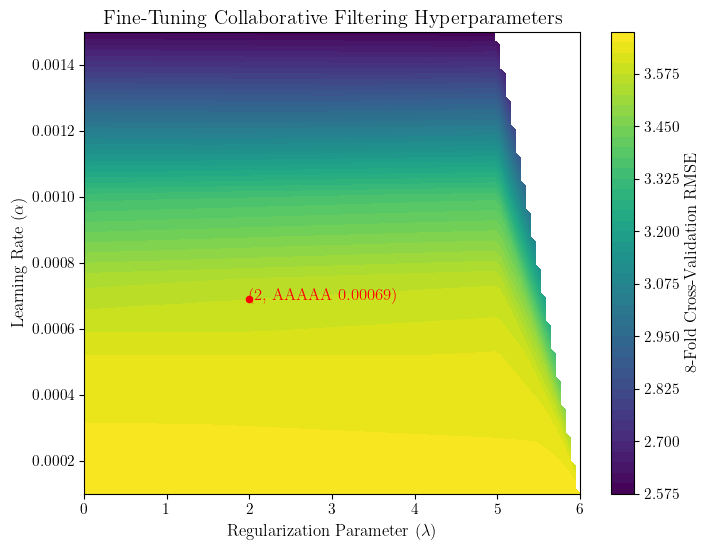

In [58]:
from scipy.interpolate import griddata

# Extract x, y, and z values
points = np.array(list(results.keys()))
x, y = points[:, 0], points[:, 1]
z = np.array(list(results.values()))

# Create a grid for interpolation
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values onto the grid
zi = griddata(points, z, (xi, yi), method='linear') #nearest, cubic, linear, quadratic

# Plot the topographic map
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(contour, label='8-Fold Cross-Validation RMSE')
#plt.scatter(x, y, color='black', s=1 , label='Data Points')
best_lambda, best_alpha = 2, 0.00069
plt.scatter(best_lambda, best_alpha, color='red', s=20)
plt.text(best_lambda, best_alpha, f"({best_lambda}, AAAAA {best_alpha})", fontsize=12, color='red')
plt.title('Fine-Tuning Collaborative Filtering Hyperparameters')
plt.xlabel(r'Regularization Parameter ($\lambda$)')
plt.ylabel(r'Learning Rate ($\alpha$)')
#plt.legend()
plt.show()

In [20]:
# choose the best hyperparameters
best_lambda, best_alpha = None, None

# Evaluate the optimized model

In [21]:
import matplotlib.pyplot as plt

#plt.plot(jhist)

In [22]:
df_to_evaluate = df_test

RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2

RMSE = np.sqrt(RMSE/len(df_to_evaluate))
RMSE

np.float64(1.9876816363697347)

In [23]:
# ...